# Twitter Text Visualized

**This notebook gathers tweets relating to selected topics and analyzes whether the sentiments in the tweets are positive, negative, or neutral**

*Disclaimer: this was created on Google Colab and uploaded to GitHub as a Jupyter notebook*

### Installing Libraries

- The Natural Language Tokenizer package divides a string into substrings by splitting on a specified string
- TwitterScraper allows us to scrape the tweets from Twitter
- vaderSentiment is used to derive the sentiments of the tweets

#### Installing Modules

In [0]:
!pip install twitterscraper
!pip install vaderSentiment
!pip install wordcloud
!pip install seaborn=0.9.0

  Running setup.py bdist_wheel for twitterscraper ... - done
  Stored in directory: /root/.cache/pip/wheels/45/50/9b/70128bca07e2bf8b5ed3f504002e9e74a6eaa5e756341b6931
Successfully built twitterscraper
    100% |████████████████████████████████| 133kB 4.4MB/s 
Invalid requirement: 'seaborn=0.9.0'
= is not a valid operator. Did you mean == ?


#### NLTK

In [0]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

from sklearn.base import BaseEstimator, TransformerMixin

class NLTKPreprocessor(BaseEstimator, TransformerMixin):
    """
    Transforms input data by using NLTK tokenization, lemmatization, and
    other normalization and filtering techniques.
    """

    def __init__(self, stopwords=None, punct=None, lower=True, strip=True):
        """
        Instantiates the preprocessor, which make load corpora, models, or do
        other time-intenstive NLTK data loading.
        """
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = set(stopwords) if stopwords else set(sw.words('english'))
        self.punct      = set(punct) if punct else set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        """
        Fit simply returns self, no other information is needed.
        """
        return self

    def inverse_transform(self, X):
        """
        No inverse transformation
        """
        return X

    def transform(self, X):
        """
        Actually runs the preprocessing on each document.
        """
        return [
            list(self.tokenize(doc)) for doc in X
        ]

    def tokenize(self, document):
        """
        Returns a normalized, lemmatized list of tokens from a document by
        applying segmentation (breaking into sentences), then word/punctuation
        tokenization, and finally part of speech tagging. It uses the part of
        speech tags to look up the lemma in WordNet, and returns the lowercase
        version of all the words, removing stopwords and punctuation.
        """
        # Break the document into sentences
        for sent in sent_tokenize(document):
            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):
                # Apply preprocessing to the token
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
                token = token.strip('_') if self.strip else token
                token = token.strip('*') if self.strip else token

                # If punctuation or stopword, ignore token and continue
                if token in self.stopwords or all(char in self.punct for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize(token, tag)
                yield lemma

    def lemmatize(self, token, tag):
        """
        Converts the Penn Treebank tag to a WordNet POS tag, then uses that
        tag to perform much more accurate WordNet lemmatization.
        """
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

#### Libraries

In [0]:
from twitterscraper import query_tweets
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import re
import datetime
import pandas as pd
import numpy as np

### Tweet Scraping
- The analysis parameters are set and a dataframe of the data we want to visualize is created

**Analysis Settings**

The following settings are used to toggle the results of the analysis



*   topic - keyword used to determine what tweets should be scraped 
*   begin_date - start date of data scraping 
*   end_date - end date of data scraping

In [0]:
topic = "cat"
begin_date = datetime.date(2018, 10, 21)
end_date =  datetime.date(2018, 11, 18)

In [0]:
list_of_tweets = query_tweets(topic, limit = 10, begindate = begin_date, 
                              enddate = end_date, poolsize = 20, lang = 'en')

INFO: queries: ['cat since:2018-10-21 until:2018-10-22', 'cat since:2018-10-22 until:2018-10-23', 'cat since:2018-10-23 until:2018-10-25', 'cat since:2018-10-25 until:2018-10-26', 'cat since:2018-10-26 until:2018-10-28', 'cat since:2018-10-28 until:2018-10-29', 'cat since:2018-10-29 until:2018-10-30', 'cat since:2018-10-30 until:2018-11-01', 'cat since:2018-11-01 until:2018-11-02', 'cat since:2018-11-02 until:2018-11-04', 'cat since:2018-11-04 until:2018-11-05', 'cat since:2018-11-05 until:2018-11-06', 'cat since:2018-11-06 until:2018-11-08', 'cat since:2018-11-08 until:2018-11-09', 'cat since:2018-11-09 until:2018-11-11', 'cat since:2018-11-11 until:2018-11-12', 'cat since:2018-11-12 until:2018-11-13', 'cat since:2018-11-13 until:2018-11-15', 'cat since:2018-11-15 until:2018-11-16', 'cat since:2018-11-16 until:2018-11-18']
INFO: Querying cat since:2018-10-21 until:2018-10-22
INFO: Querying cat since:2018-10-22 until:2018-10-23
INFO: Querying cat since:2018-10-23 until:2018-10-25
INFO:

In [0]:
dt = []
for tweet in list_of_tweets:
    dt.append({'Tweet Id': tweet.id, 'Twitter Handle' : tweet.user,
               'User Fullname': tweet.fullname, 'Tweet Text': tweet.text, 'Tweet Time': tweet.timestamp})

In [0]:
dashtweet = pd.DataFrame(dt)
dashtweet = dashtweet.set_index('Tweet Id')

tweets = dashtweet["Tweet Text"]
vtweets = list(tweets)

### Sentiment Analysis & Visualizations

#### Sentiment Analysis

The tweets are broken down into tokens. Their sentiments are then extracted.

In [0]:
trans = NLTKPreprocessor()
tok = trans.transform(tweets)
tok = re.sub(r'^https?:\/\/.*[\r\n]*', '', str(tok), flags=re.MULTILINE)
vs = []

In [0]:
analyzer = SentimentIntensityAnalyzer()
for sentence in vtweets:
    vs.append(analyzer.polarity_scores(sentence))

In [0]:
vad = pd.DataFrame(vs)
vad.index = dashtweet["Tweet Time"]

#### Word Cloud
From the Word Cloud, we can interpret the largest words as being the most frequently mentioned in the tweets.

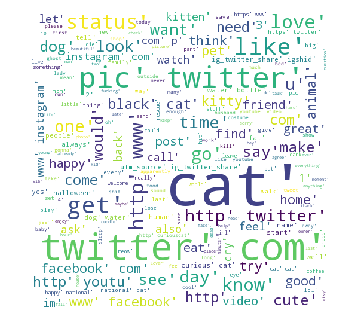

In [0]:
wordcloud = WordCloud(stopwords = STOPWORDS,
                      background_color = 'white',
                      width = 500,
                      height = 500,
                     ).generate(str(tok))


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Horizontal Bar Plot
The following code is to create the feature 'tag' to classify the overall sentiment of the tweet. <br>

The feature is then resampled and the average of each sentiment per day is visualized as a horizontal bar plot.

In [0]:
tag = pd.DataFrame(np.NaN, columns = ['positive', 'neutral', 'negative', 'other'], index = vad.index)

for i, v in enumerate(vs):
    comp = v['compound']
    if comp > 0.05:
        tag['positive'][i] = 1
    elif -0.05 <= comp <= 0.05:
        tag['neutral'][i] = 1
    elif comp < -0.05:
        tag['negative'][i] = 1
    else:
        tag['other'][i] = 1

In [0]:
ntag = tag.resample('D').sum()

In [0]:
ntag = ntag.apply(lambda x: x/x.sum(), axis=1) 

In [0]:
ntag = ntag.replace(0, np.NaN)
ntag = ntag.fillna(method = 'ffill')

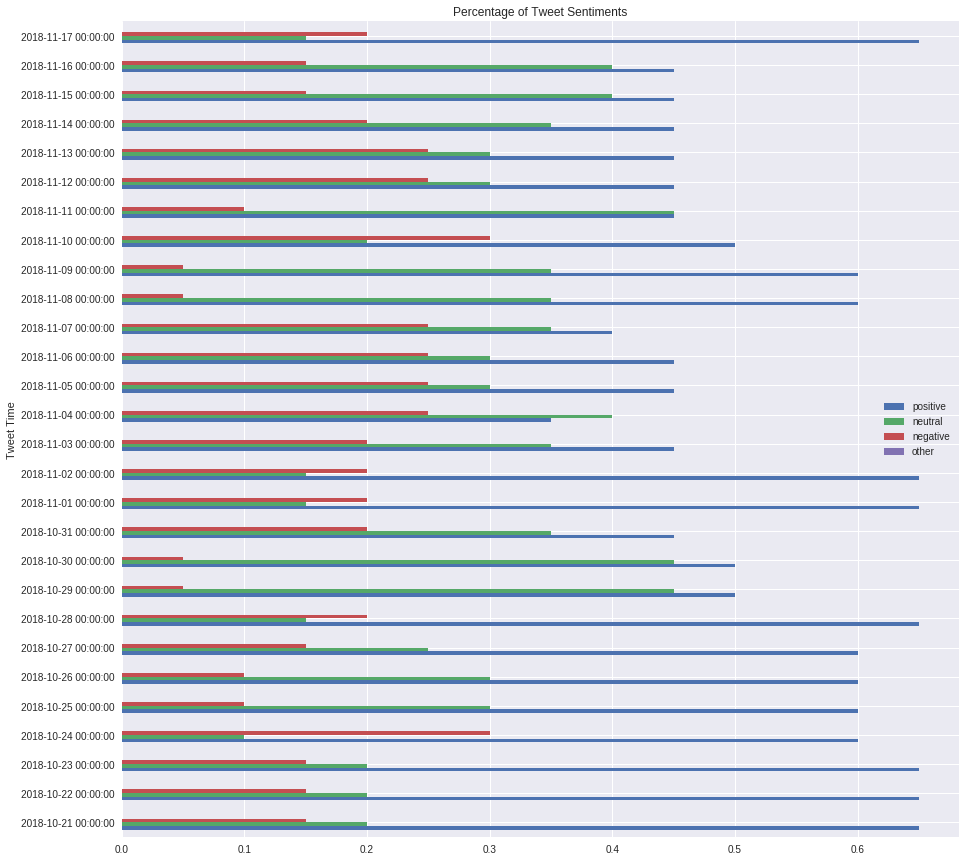

In [0]:
ntag.plot(kind = 'barh', figsize=(15, 15), title = 'Percentage of Tweet Sentiments')